Install packages

In [ ]:
!pip install -r requirements.txt
!pip install python-terrier matplotlib pandas

Add ifind

In [ ]:
!export PYTHONPATH="${PYTHONPATH}:./ifind"

Prepare topics

In [1]:
with open('wtr/queries_qrels/queries.txt') as f_in:
    for line in f_in.readlines():
        splits = line.split(' ')
        file_name = 'wtr/topics/topic.' + splits[0]
        with open(file_name, 'w') as f_out:
            f_out.write(' '.join(splits[1:]))

In [7]:
!cd ./sims/output && rm *

Run simulations

In [ ]:
!cd ./simiir/ && python run_simiir.py ../sims/wtr_simulation.xml

In [49]:
import glob
import pandas as pd
def get_log_props(log_path):
    parts = log_path.split('-')
    if len(parts) > 5:
        topic = parts[1]
        depth = parts[2].split('user')[-1]
        modality = parts[3]
        strat = parts[4]
        prob = parts[5].split(".")[0]

        return (topic, depth, modality, strat, prob)
    else:
        return 

log_root_path = "sims/output/"
#load all logs
log_files = glob.glob(f"{log_root_path}*.log")
topics = set()
depths = set()
modalities  = set()
strats = set()
probs = set()

log_cnt = 0

log_df = pd.DataFrame(columns=['Depth', 'Modality', 'Strat', 'Probability', 'Topics'])

for path in log_files:
    res = get_log_props(path)

    if res:
        log_cnt +=1
        topic, depth, modality, strat, prob = res
        topics.add(topic)
        depths.add(depth)
        modalities.add(modality)
        strats.add(strat)
        probs.add(prob)

        row = {'Depth' : depth, 'Modality': modality, 'Strat' : strat, 'Probability' : prob,  'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])


print(f"number of log files: {log_cnt}")
print(f"topics: {sorted(topics, key=lambda x: int(x))}")
print(f"depths: {sorted(depths, key=lambda x: int(x))}")
print(f"modalities: {modalities}")
print(f"strats: {strats}")
print(f"probs: {probs}")

log_df.groupby(['Depth', 'Modality', 'Strat', 'Probability'])['Topics'].agg(lambda x: len(x)).reset_index()

number of log files: 3180
topics: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
depths: ['3', '5', '10', '20', '30', '50']
modalities: {'PageTitle', 'oracle', 'entity', 'textBefore', 'textAfter', 'random'}
strats: {'d2qNofeedback', 'gpt', 'd2qfeedback'}
probs: {'rprob07nprob03', 'rprob05nprob05', 'rprob10nprob00', 'rprob06nprob03', 'rprob09nprob03', 'rprob08nprob03'}


,Depth,Modality,Strat,Probability,Topics
0,10,PageTitle,d2qNofeedback,rprob10nprob00,60
1,10,PageTitle,d2qfeedback,rprob06nprob03,60
2,10,PageTitle,d2qfeedback,rprob07nprob03,60
3,10,PageTitle,d2qfeedback,rprob08nprob03,60
4,10,PageTitle,d2qfeedback,rprob09nprob03,60
5,10,PageTitle,d2qfeedback,rprob10nprob00,60
6,10,PageTitle,gpt,rprob06nprob03,60
7,10,PageTitle,gpt,rprob07nprob03,60
8,10,PageTitle,gpt,rprob08nprob03,60
9,10,PageTitle,gpt,rprob09nprob03,60


# Evaluations

## Modalities

### sDCG 

In [3]:
topics_to_analyze = range(1,61)

dict_keys(['PageTitle', 'random', 'textBefore', 'textAfter', 'entity', 'oracle'])


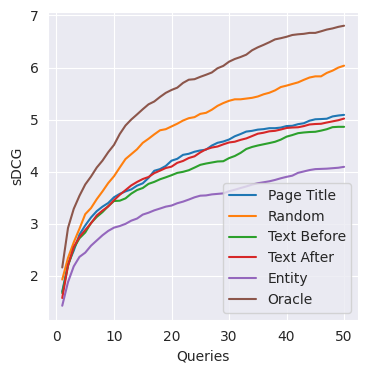

In [58]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

modality_eval = {}
sdcg_eval = {}

# TODO: update/extend modalities
modalities = ['PageTitle', 'random', 'textBefore','textAfter', 'entity', 'oracle']
depth = 10
query_types = {'d2qNofeedback', 'd2qfeedback', 'gpt'}
query_type = 'd2qfeedback'


for modality in modalities:
    
    if modality == 'random':
        probabilities = 'rprob05nprob05'
    else:
        probabilities = 'rprob10nprob00'
        
    for topic in topics_to_analyze:
        
        log_path = log_root_path + "wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + "-" + modality + "-" + query_type + "-" + probabilities + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    modality_eval[modality] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()


print(modality_eval.keys())


modality_eval['Page Title'] = modality_eval.pop('PageTitle')
modality_eval['Random'] = modality_eval.pop('random')
modality_eval['Text Before'] = modality_eval.pop('textBefore')
modality_eval['Text After'] = modality_eval.pop('textAfter')
modality_eval['Entity'] = modality_eval.pop('entity')
modality_eval['Oracle'] = modality_eval.pop('oracle')
pd.DataFrame.from_dict(modality_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))
plt.savefig(f'figures/sdcg.modality.{query_type}.depth={depth}.pdf', bbox_inches="tight")
plt.show()

### Effort vs. Effect

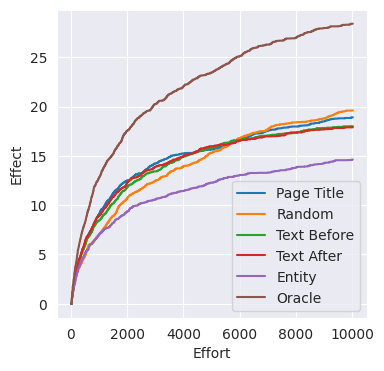

In [60]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

modality_eval = {}
gain_all = {}

# TODO: update/extend modalities
modalities = ['random', 'PageTitle', 'textBefore','textAfter', 'entity', 'oracle']

depth = 10
query_types = {'d2qNofeedback', 'd2qfeedback', 'gpt'}
query_type = "d2qfeedback" 

for modality in modalities:
    
    if modality == 'random':
        probabilities = 'rprob05nprob05' 
    else:
        probabilities = 'rprob10nprob00'

    for topic in topics_to_analyze:
        
        log_path = log_root_path + "wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + "-" + modality + "-" + query_type + "-" + probabilities + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    modality_eval[modality] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()

modality_eval['Page Title'] = modality_eval.pop('PageTitle')
modality_eval['Random'] = modality_eval.pop('random')
modality_eval['Text Before'] = modality_eval.pop('textBefore')
modality_eval['Text After'] = modality_eval.pop('textAfter')
modality_eval['Entity'] = modality_eval.pop('entity')
modality_eval['Oracle'] = modality_eval.pop('oracle')
pd.DataFrame.from_dict(modality_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))
plt.savefig(f'figures/effort.effect.modality.{query_type}.depth={depth}.pdf', bbox_inches="tight")
plt.show()

## Depth evaluation

### sDCG

#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b


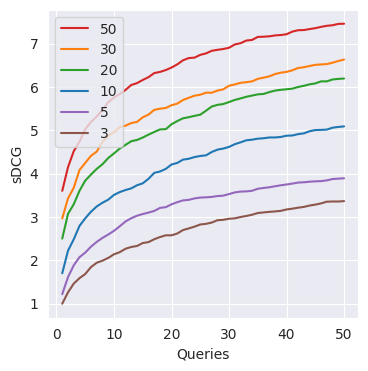

In [114]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
sdcg_eval = {}

depths = [50, 30, 20, 10, 5, 3]
modality = 'PageTitle'
query_types = {'d2qNofeedback', 'd2qfeedback', 'gpt'}
query_type = 'd2qfeedback'
probabilities = 'rprob10nprob00'

for depth in depths:

    for topic in topics_to_analyze:
        
        log_path = log_root_path +"wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probabilities + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    depth_eval[depth] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()
    
pd.DataFrame.from_dict(depth_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))

ax = plt.gcf().axes[0]
lines = ax.get_lines()
for line in lines:
    print(line.get_color())
    

lines[0].set_color("#d62728") 
lines[3].set_color("#1f77b4") 

plt.legend()

plt.savefig(f'figures/sdcg.depth.{query_type}.pdf', bbox_inches="tight")
plt.show()

### Effort vs. Effect

#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b


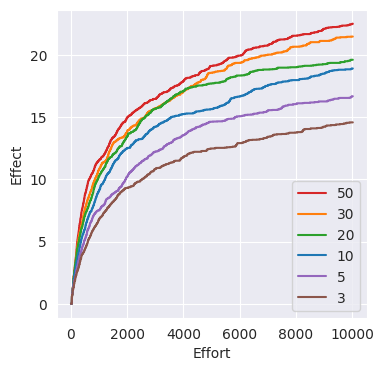

In [113]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}

depths = [50, 30, 20, 10, 5, 3]
modality = 'PageTitle'
query_types = {'d2qNofeedback', 'd2qfeedback', 'gpt'}
query_type = 'd2qfeedback'
probabilities = 'rprob10nprob00'


for depth in depths:

    for topic in topics_to_analyze:
        
        log_path = log_root_path +"wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probabilities + ".log"
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    depth_eval[depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))

ax = plt.gcf().axes[0]
lines = ax.get_lines()
for line in lines:
    print(line.get_color())
    

lines[0].set_color("#d62728") 
lines[3].set_color("#1f77b4") 

plt.legend()

plt.savefig(f'figures/effort.effect.depth.{query_type}.pdf', bbox_inches="tight")
plt.show()

## Browsing behavior

### sDCG

dict_keys(['rprob10nprob00', 'rprob09nprob03', 'rprob08nprob03', 'rprob07nprob03', 'rprob06nprob03', 'rprob05nprob05'])


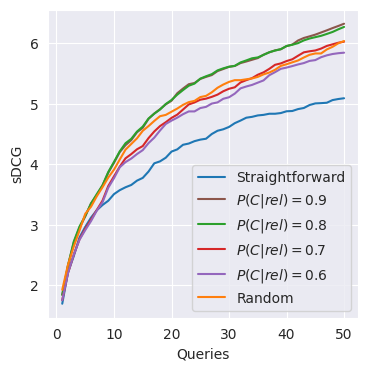

In [93]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

prob_eval = {}
sdcg_eval = {}

depth = 10
query_types = {'d2qNofeedback', 'd2qfeedback', 'gpt'}
query_type = 'd2qfeedback'
probabilities = ['rprob10nprob00','rprob09nprob03', 'rprob08nprob03', 'rprob07nprob03', 'rprob06nprob03', 'rprob05nprob05']

for probability in probabilities:

    if probability == 'rprob05nprob05':
        modality = 'random' 
    else:
        modality = 'PageTitle'

    for topic in topics_to_analyze:
        
        log_path = log_root_path +"wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probability + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    prob_eval[probability] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()



pd.DataFrame.from_dict(prob_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))

print(prob_eval.keys())



ax = plt.gcf().axes[0]
lines = ax.get_lines()
for line in lines:
    #print(line.get_color())
    continue

lines[-1].set_color("#ff7f0e") 
lines[1].set_color("#8c564b") 


plt.legend([r'Straightforward' , r'$P(C|rel) = 0.9$', r'$P(C|rel) = 0.8$' ,  r'$P(C|rel) = 0.7$',  r'$P(C|rel) = 0.6$', 'Random'])
plt.savefig(f'figures/sdcg.browse.{query_type}.pdf', bbox_inches="tight")
plt.show()

### Effort vs. Effect

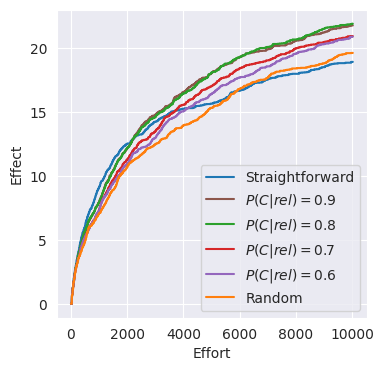

In [94]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

prob_eval = {}
gain_all = {}

depth = 10
query_types = {'d2qNofeedback', 'd2qfeedback', 'gpt'}
query_type = 'd2qfeedback'
probabilities = ['rprob10nprob00','rprob09nprob03', 'rprob08nprob03', 'rprob07nprob03', 'rprob06nprob03', 'rprob05nprob05']

for probability in probabilities:

    if probability == 'rprob05nprob05':
        modality = 'random' 
    else:
        modality = 'PageTitle'

    for topic in topics_to_analyze:
        
        log_path = log_root_path+"wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probability + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    prob_eval[probability] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(prob_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))

ax = plt.gcf().axes[0]
lines = ax.get_lines()
for line in lines:
    #print(line.get_color())
    continue

lines[-1].set_color("#ff7f0e") 
lines[1].set_color("#8c564b") 


plt.legend([r'Straightforward' , r'$P(C|rel) = 0.9$', r'$P(C|rel) = 0.8$' ,  r'$P(C|rel) = 0.7$',  r'$P(C|rel) = 0.6$', 'Random'])

plt.savefig(f'figures/effort.effect.browse.{query_type}.pdf', bbox_inches="tight")
plt.show()

dict_keys(['d2qfeedback', 'd2qNofeedback', 'gpt'])
#1f77b4
#ff7f0e
#2ca02c


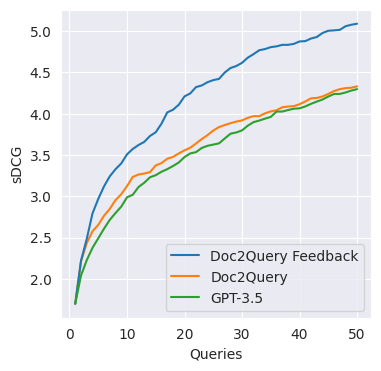

In [108]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

query_type_eval = {}
query_type_eval_all = {}
sdcg_eval = {}

depth = 10
query_types = ['d2qfeedback', 'd2qNofeedback', 'gpt']
probability = "rprob10nprob00"

for query_type in query_types:

    if probability == 'rprob05nprob05':
        modality = 'random' 
    else:
        modality = 'PageTitle'

    for topic in topics_to_analyze:
        
        log_path = log_root_path+"wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probability + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    query_type_eval[query_type] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()
    query_type_eval_all[query_type] = sdcg_eval.copy()



print(query_type_eval.keys())
query_type_eval['Doc2Query'] = query_type_eval.pop('d2qNofeedback')
query_type_eval['Doc2Query Feedback'] = query_type_eval.pop('d2qfeedback')
query_type_eval['GPT-3.5'] = query_type_eval.pop('gpt')

pd.DataFrame.from_dict(query_type_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))

ax = plt.gcf().axes[0]
lines = ax.get_lines()
for line in lines:
    print(line.get_color())
    #continue

lines[0].set_color("#ff7f0e") 
lines[1].set_color("#1f77b4") 

handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [1,0,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig(f'figures/sdcg.browse.{depth}.pdf', bbox_inches="tight")
plt.show()

In [117]:
df_types = {}

for type in query_types:
    query_df = pd.DataFrame.from_dict(query_type_eval_all[type], orient="index").stack().to_frame()
    query_df = pd.DataFrame(query_df[0].values.tolist(), index=query_df.index).reset_index(names=['topic', 'query'])
    query_df = query_df.rename(columns={0: 'gain'})
    query_df = query_df[query_df.apply(lambda row: row['query'] <=50, axis=1)]
    df_types[type] = query_df


<Axes: xlabel='query', ylabel='gain'>

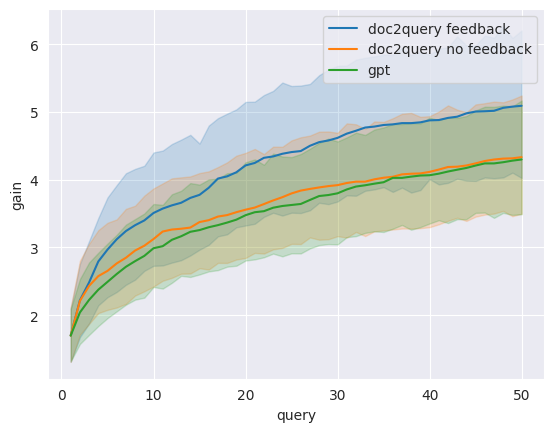

In [118]:
sns.lineplot(data=df_types['d2qfeedback'], x='query', y='gain', label="doc2query feedback")
sns.lineplot(data=df_types['d2qNofeedback'], x='query', y='gain',  label="doc2query no feedback")
sns.lineplot(data=df_types['gpt'], x='query', y='gain', label="gpt")
#plt.legend(loc="upper left")

#1f77b4
#ff7f0e
#2ca02c


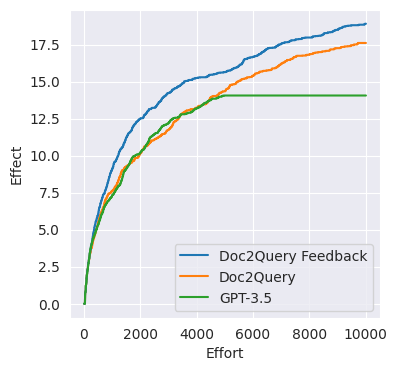

In [115]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

query_type_eval = {}
gain_all = {}

depth = 10
query_types = ['gpt', 'd2qfeedback', 'd2qNofeedback']
probability = "rprob10nprob00"

for query_type in query_types:

    if probability == 'rprob05nprob05':
        modality = 'random' 
    else:
        modality = 'PageTitle'

    for topic in topics_to_analyze:
        
        log_path = log_root_path+"wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probability + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    query_type_eval[query_type] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()

query_type_eval['Doc2Query'] = query_type_eval.pop('d2qNofeedback')
query_type_eval['Doc2Query Feedback'] = query_type_eval.pop('d2qfeedback')
query_type_eval['GPT-3.5'] = query_type_eval.pop('gpt')
pd.DataFrame.from_dict(query_type_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))

ax = plt.gcf().axes[0]
lines = ax.get_lines()
for line in lines:
    print(line.get_color())
    #continue

lines[0].set_color("#ff7f0e") 
lines[1].set_color("#1f77b4") 

handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [1,0,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


plt.savefig(f'figures/effort.effect.browse.{depth}.pdf', bbox_inches="tight")
plt.show()

<Axes: xlabel='gain', ylabel='Count'>

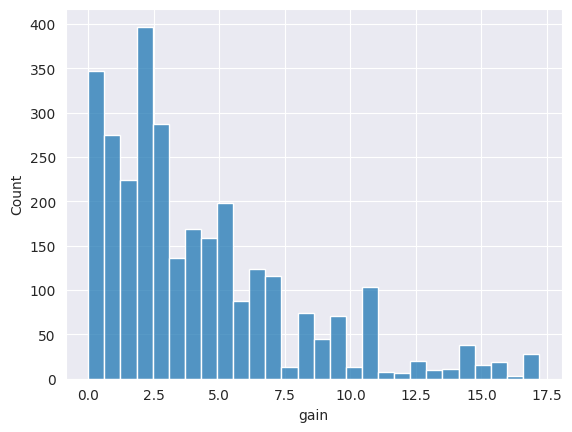

In [13]:
sns.histplot(df_types['d2qfeedback']['gain'])